## Census Data Discovery
### Urban Renewal Explorer - Exploratory Analysis

### Background
A main component of my final project is analyzing socioeconomic change in neighborhoods that experienced urban renewal over several decades. The challenge is that Census tract boundaries change regularly which makes direct comparison over time more complicated than simply lining up decennial Census data.

Based on online research, and a mention in MUSA 5080, the [Longitudinal Tract Data Base](https://s4.ad.brown.edu/projects/diversity/Researcher/Bridging.htm) (LTDB) seemed like a promising contender to address this challenge. This database provides estimates within 2010 tract boundaries for tract-level census data, going back as early as 1970. Of course, this excludes some of the immediate impacts of Urban Renewal in the 50s and 60s, and makes it harder to interpret 2020 data (outisde of race). This can be explored in future improvements to this project.

Since usage of this database was not covered in class, **I conduct some code exploration below.**

- First, I load in Cincinnati City boundaries, including neighborhoods.
- Then I bring in regular Census API data and produce some visualizations.
- Finally, I explore the LTDB data.

In [35]:
# Setup
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cenpy
import pygris
import folium
import branca.colormap as cm

### Cincinnati Neighborhood Boundaries & Census Tract Exploration
In the next few code blocks, I load in 2020 Cincinnati Statistic Neighborhood Approximation (SNA) Boundaries, retrieved from [Cincinnati Data] (https://data.cincinnati-oh.gov/dataset/Cincinnati-Statistical-Neighborhood-Approximations/i9zh-juvu/about_data). I also grab census tracts using pygris for Hamilton County, plot that, and then filter down to census tracts that include any part of Cincinnati.

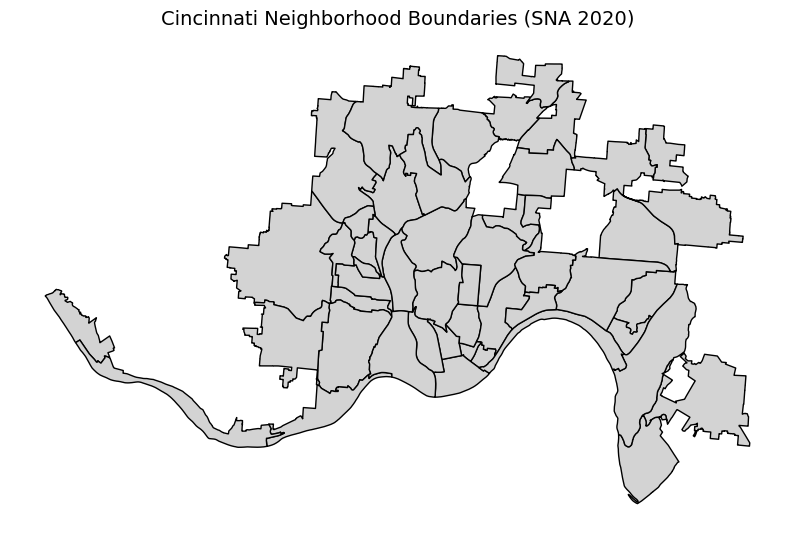

In [2]:
# Load Cincinnati neighborhood boundaries
cinci_sna_gdf = gpd.read_file("../data/boundaries/Cinci_SNA_2020.geojson")

fig, ax = plt.subplots(figsize=(10, 10))
cinci_sna_gdf.plot(ax=ax, edgecolor="black", facecolor="lightgray")

ax.set_title("Cincinnati Neighborhood Boundaries (SNA 2020)", fontsize=14)
ax.axis("off")

output_filename = "census-data-output/cinci_sna_boundaries.png"
plt.savefig(
    output_filename,
    dpi=200,
    bbox_inches='tight',
    facecolor='white',
    transparent=True
)
plt.show()

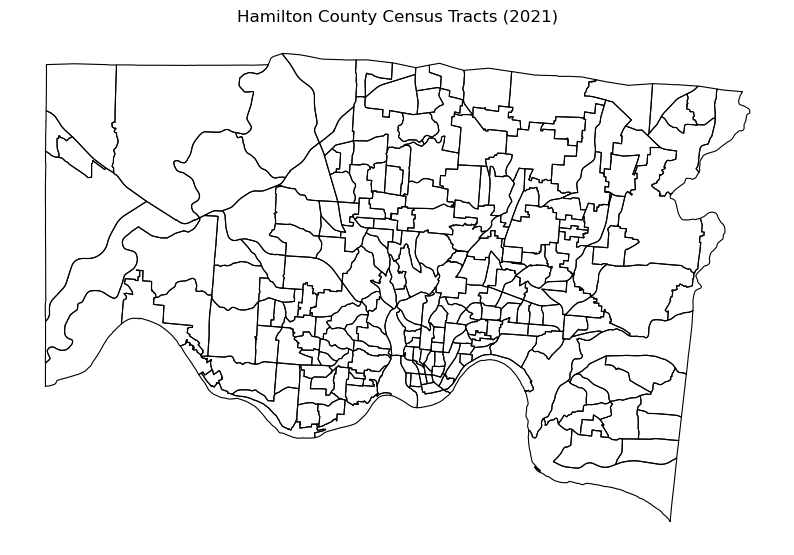

In [3]:
# FIPS Code for Ohio = 39. Pulling all tracts for 2021
ohio_tracts = pygris.tracts(state="39", year=2021)

# FIPS Code for Hamilton County = 061
hamilton_tracts = ohio_tracts[ohio_tracts["COUNTYFP"] == "061"].copy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hamilton_tracts.plot(
    edgecolor="black",
    facecolor="none",
    linewidth=0.8,
    ax=ax
)
ax.set_title("Hamilton County Census Tracts (2021)")
ax.axis("off")

output_filename = "census-data-output/hamilton_county_tracts.png"
plt.savefig(
    output_filename,
    dpi=200,
    bbox_inches='tight',
    facecolor='white',
    transparent=True
)
plt.show()


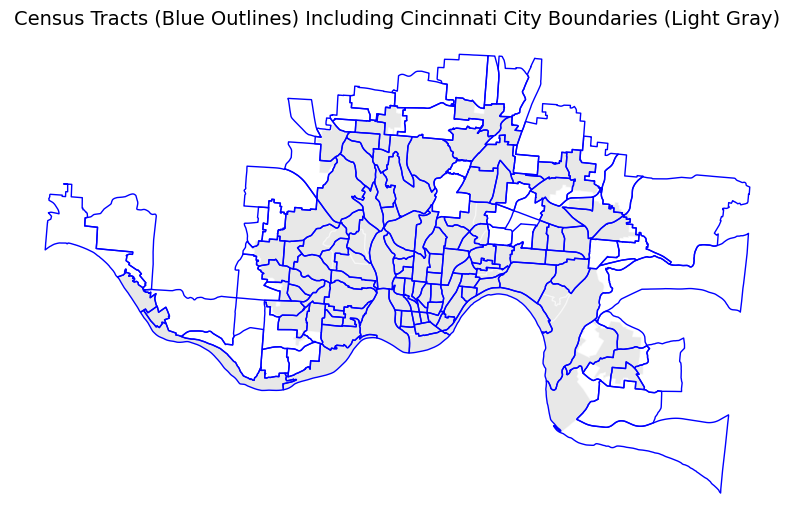

In [4]:
# Ensure CRS Match
hamilton_tracts = hamilton_tracts.to_crs(cinci_sna_gdf.crs)

#inner join to keep only tracts that intersect with the neighborhood boundaries
cinci_tracts = gpd.sjoin(
    hamilton_tracts,
    cinci_sna_gdf,
    how="inner",
    predicate="intersects"
)

# Remove any duplicate tracts
cinci_tracts = cinci_tracts.drop_duplicates(subset=['GEOID'])

# Plot neighborhood as gray overlay
fig, ax = plt.subplots(figsize=(10, 10))
cinci_sna_gdf.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5)

# Plot tracts
cinci_tracts.plot(
    ax=ax,
    edgecolor="blue",
    facecolor="none",
    linewidth=1,
    label="Filtered Tracts"
)
ax.set_title("Census Tracts (Blue Outlines) Including Cincinnati City Boundaries (Light Gray)", fontsize=14)
ax.axis("off")

output_filename = "census-data-output/census_tracts_cinci_sna.png"
plt.savefig(
    output_filename,
    dpi=200,
    bbox_inches='tight',
    facecolor='white',
    transparent=True
)
plt.show()

### 2021 Census Data Exploration
In the following code blocks, I grab data from the 2021 ACS 5-year estimate. I also map that against the Cincinnati Census Tracts.

In [5]:
# ACS 5-year dataset (2021)
acs = cenpy.remote.APIConnection("ACSDT5Y2021")

# B19013_001E = Median Household Income
variables = ["B19013_001E"]

income_data = acs.query(
    cols=variables,
    geo_unit="tract",
    geo_filter={"state": "39", "county": "061"}
)
income_data["GEOID"] = (
        income_data["state"].astype(str) +
        income_data["county"].astype(str) +
        income_data["tract"].astype(str).str.zfill(6)
)
income_data = income_data.rename(columns={"B19013_001E": "Median_HH_Income"})

print(income_data.head())


  Median_HH_Income state county   tract        GEOID
0            18049    39    061  000200  39061000200
1            94100    39    061  000700  39061000700
2            78421    39    061  000900  39061000900
3            79007    39    061  001000  39061001000
4            66680    39    061  001100  39061001100


In [6]:
# Here, I merge the income data with Cinci Tracts
cinci_tracts["GEOID"] = cinci_tracts["GEOID"].astype(str)

cinci_income_tracts = cinci_tracts.merge(
    income_data[["GEOID", "Median_HH_Income"]],
    on="GEOID",
    how="left"
)

# Convert income to numeric for mapping
cinci_income_tracts["Median_HH_Income"] = pd.to_numeric(
    cinci_income_tracts["Median_HH_Income"], errors='coerce'
)

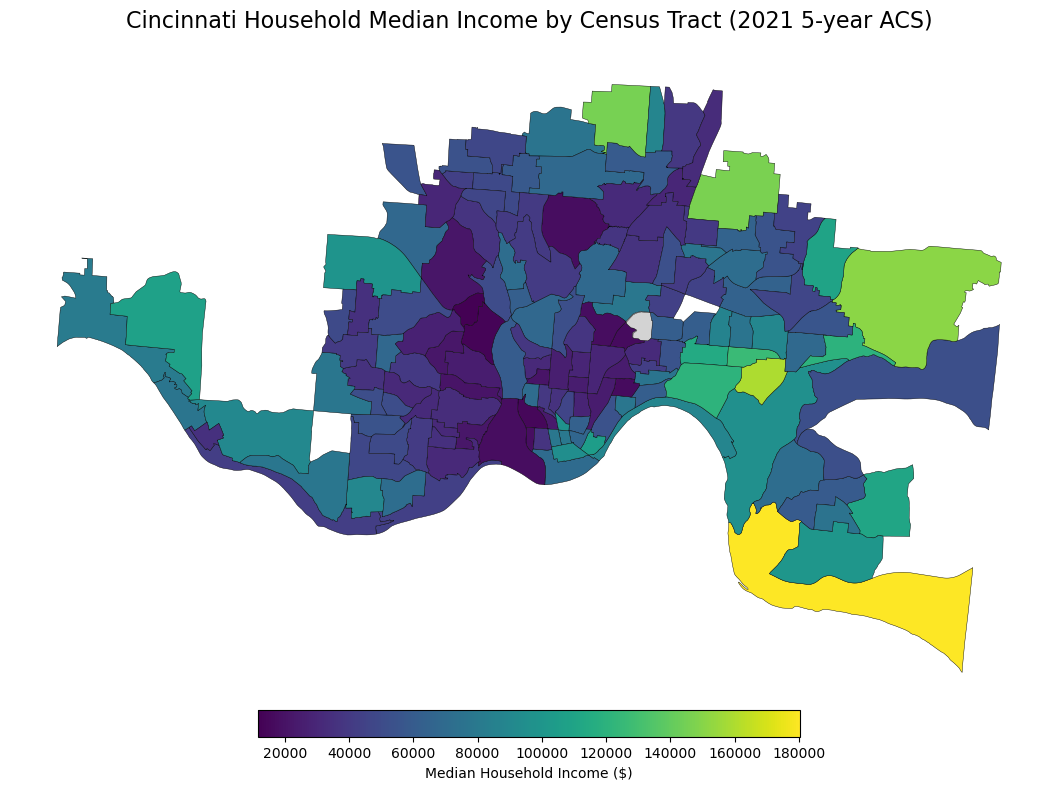

In [7]:
# Replace the specific Census null flag with actual NaN
cinci_income_tracts.loc[cinci_income_tracts["Median_HH_Income"] < 0, "Median_HH_Income"] = None

fig, ax = plt.subplots(figsize=(14, 10))
plot = cinci_income_tracts.plot(
    column="Median_HH_Income",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={
        "label": "Median Household Income ($)",
        "orientation": "horizontal",
        "shrink": 0.5,
        "pad": 0.01,
        "fmt": "${x:,.0f}"
    }
)
ax.set_title("Cincinnati Household Median Income by Census Tract (2021 5-year ACS)", fontsize=16, pad=20)
ax.axis("off")

output_filename = "census-data-output/cinci_mhh_inc.png"
plt.savefig(
    output_filename,
    dpi=200,
    bbox_inches='tight',
    facecolor='white',
    transparent=True
)
plt.show()

### Target Neighborhoods
My report is focused on urban renewal that impacted the urban core of Cincinnati, specifically the West End and Queensgate. Neighborhoods nearby, primarily Over-the-Rhine, Downtown, and Pendleton were also impacted by Urban Renewal but kept their urban fabric (where as the West End and Queensgate were almost entirely demolished in an attempt to become an industrial/logistics zone).

/var/folders/h9/nk_01ycx2t31cb3cqx1dyr8m0000gn/T/ipykernel_4677/512717585.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(focus_areas.geometry.centroid.x,
/var/folders/h9/nk_01ycx2t31cb3cqx1dyr8m0000gn/T/ipykernel_4677/512717585.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  focus_areas.geometry.centroid.y,


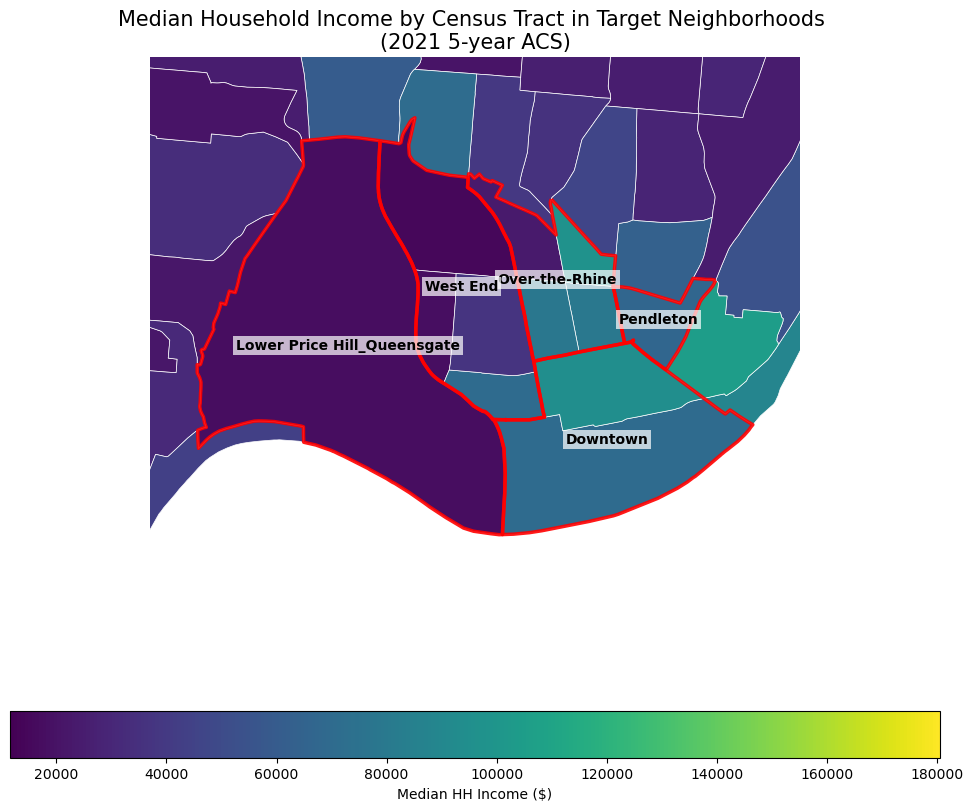

In [8]:
target_neighborhoods = [
    "West End",
    "Lower Price Hill_Queensgate",
    "Pendleton",
    "Downtown",
    "Over-the-Rhine"
]
focus_areas = cinci_sna_gdf[cinci_sna_gdf['SNA_NAME'].isin(target_neighborhoods)]

# Get the bounding box: [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = focus_areas.total_bounds

# Add a small buffer (approx 5%) so the edges aren't touching the frame
buffer = 0.005
xlim = ([minx - buffer, maxx + buffer])
ylim = ([miny - buffer, maxy + buffer])


fig, ax = plt.subplots(figsize=(12, 10))
cinci_income_tracts.plot(
    column="Median_HH_Income",
    cmap="viridis",
    edgecolor="white",
    linewidth=0.5,
    ax=ax,
    legend=True,
    legend_kwds={'label': "Median HH Income ($)", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"}
)

focus_areas.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2.5,
    alpha=0.9
)

# Add neighborhood names
for x, y, label in zip(focus_areas.geometry.centroid.x,
                       focus_areas.geometry.centroid.y,
                       focus_areas['SNA_NAME']):
    ax.text(x, y, label, fontsize=10, fontweight='bold',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Median Household Income by Census Tract in Target Neighborhoods \n(2021 5-year ACS)", fontsize=15)
ax.axis("off")

output_filename = "census-data-output/cinci_target_neigh_inc.png"
plt.savefig(
    output_filename,
    dpi=200,
    bbox_inches='tight',
    facecolor='white',
    transparent=True
)
plt.show()

### Longitudinal Tract Database (LTDB)
Finally, I wanted to view Median Household Income across the Hamilton County Area, with an emphasis on my focus neighborhoods across time (from 1970 to 2015). For this, I used the aforementioned LTDB which standardizes census data to 2010 tract boundaries.
This required a fair amount of data processing, as their website is a bit out of data and they do not have an API. Instead, you must download the CSVs with estimates, and use their codebook to understand column headers. These are not standardizes across files!

In [14]:
# --- Step 1: Load Hamilton County tracts (2010) ---
ohio_tracts = pygris.tracts(state='39', year=2010)  # Ohio
# Filter for Hamilton County FIPS = '061'
hamilton_tracts_2010 = ohio_tracts[ohio_tracts['COUNTYFP10'] == '061']

# --- Step 2: Load LTDB CSVs into dictionary ---
folder = "../data/ltdb_std_all_sample/"

dfs = {
    '1970': pd.read_csv(f"{folder}ltdb_std_1970_sample.csv", encoding='latin1'),
    '1980': pd.read_csv(f"{folder}ltdb_std_1980_sample.csv", encoding='latin1'),
    '1990': pd.read_csv(f"{folder}ltdb_std_1990_sample.csv", encoding='latin1'),
    '2008': pd.read_csv(f"{folder}LTDB_std_200812_Sample.csv", encoding='latin1'),
    '2015': pd.read_csv(f"{folder}LTDB_std_201519_Sample.csv", encoding='latin1'),
}

# --- Step 3: Define county/state columns ---
county_cols = {
    '1970': ('county', 'state'),
    '1980': ('county', 'state'),
    '1990': ('county', 'state'),
    '2008': ('countya', 'statea'),
    '2015': ('countya', 'statea')
}

county_vals = {
    '1970': ('Hamilton County', 'OH'),
    '1980': ('Hamilton County', 'OH'),
    '1990': ('Hamilton County', 'OH'),
    '2008': (' Hamilton County', ' Ohio'),
    '2015': (' Hamilton County', ' Ohio')
}

# --- Step 4: HH income columns ---
hhinc_cols = {
    '1970': 'HINC70',
    '1980': 'hinc80',
    '1990': 'HINC90',
    '2008': 'hinc12',
    '2015': 'hinc19'
}

# --- Step 5: Tract column per year ---
tractid_cols = {
    '1970': 'TRTID10',
    '1980': 'trtid10',
    '1990': 'TRTID10',
    '2008': 'tractid',
    '2015': 'tractid'
}

# --- Step 6: Filter for Hamilton County ---
print("=== Filtering for Hamilton County ===")
for year, df in dfs.items():
    county_col, state_col = county_cols[year]
    county_val, state_val = county_vals[year]

    # Filter for Hamilton County
    dfs[year] = df[(df[county_col] == county_val) & (df[state_col] == state_val)].copy()
    print(f"{year}: {len(dfs[year])} Hamilton County tracts found")


/var/folders/h9/nk_01ycx2t31cb3cqx1dyr8m0000gn/T/ipykernel_4677/3624253690.py:10: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,49,51,60) have mixed types. Specify dtype option on import or set low_memory=False.
  '1970': pd.read_csv(f"{folder}ltdb_std_1970_sample.csv", encoding='latin1'),
/var/folders/h9/nk_01ycx2t31cb3cqx1dyr8m0000gn/T/ipykernel_4677/3624253690.py:12: DtypeWarning: Columns (11,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  '1990': pd.read_csv(f"{folder}ltdb_std_1990_sample.csv", encoding='latin1'),


=== Filtering for Hamilton County ===
1970: 222 Hamilton County tracts found
1980: 222 Hamilton County tracts found
1990: 222 Hamilton County tracts found
2008: 222 Hamilton County tracts found
2015: 222 Hamilton County tracts found


In [15]:
# --- Step 7: Merge with GeoDataFrame using tract IDs ---
print("\n=== Merging with Census Geography ===")
merged_dfs = {}

for year, df in dfs.items():
    if len(df) == 0:
        print(f"{year}: No data after county filter, skipping...")
        continue

    tractid_col = tractid_cols[year]

    # Extract last 6 digits from tract ID (format is SSCCCTTTTTT where TT is tract)
    # For Hamilton County, Ohio (39061), we want the last 6 digits
    df['tract_6digit'] = df[tractid_col].astype(str).str[-6:]

    # Check for matches
    matches = df['tract_6digit'].isin(hamilton_tracts_2010['TRACTCE10']).sum()
    print(f"{year}: {matches}/{len(df)} tracts match census geography")

    # Perform merge
    merged = hamilton_tracts_2010.merge(
        df[[tractid_col, 'tract_6digit', hhinc_cols[year]]],
        left_on='TRACTCE10',
        right_on='tract_6digit',
        how='left'
    )

    # Keep geometry and HH income
    merged = merged[['geometry', hhinc_cols[year]]].copy()
    merged.rename(columns={hhinc_cols[year]: 'income'}, inplace=True)
    merged_dfs[year] = merged

    print(f"{year}: Final result - {len(merged)} tracts, {merged['income'].notna().sum()} with income data")


=== Merging with Census Geography ===
1970: 222/222 tracts match census geography
1970: Final result - 222 tracts, 222 with income data
1980: 222/222 tracts match census geography
1980: Final result - 222 tracts, 217 with income data
1990: 222/222 tracts match census geography
1990: Final result - 222 tracts, 222 with income data
2008: 222/222 tracts match census geography
2008: Final result - 222 tracts, 222 with income data
2015: 222/222 tracts match census geography
2015: Final result - 222 tracts, 222 with income data


In [49]:
import folium
import branca.colormap as cm

m = folium.Map(location=[39.1031, -84.5120], zoom_start=11, tiles=None)
tile_url = 'https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png'
tile_attribution = '&copy; OpenStreetMap &copy; CARTO'

colormap = cm.LinearColormap(
    colors=['#f7fbff', '#08306b'],
    vmin=0,
    vmax=150000,
    caption='Household Income ($)'
)


for year in sorted(merged_dfs.keys()):
    gdf = merged_dfs[year]

    if gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs(epsg=4326)

    year_group = folium.FeatureGroup(name=f"Income {year}", overlay=False)
    folium.TileLayer(tile_url, attr=tile_attribution).add_to(year_group)

    valid_data = gdf.dropna(subset=['income'])
    folium.GeoJson(
        valid_data,
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties']['income']),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['income'],
            aliases=['Income: $'],
            localize=True
        )
    ).add_to(year_group)

    year_group.add_to(m)

if focus_areas.crs != 'EPSG:4326':
    focus_areas = focus_areas.to_crs(epsg=4326)
focus_group = folium.FeatureGroup(name="Target Neighborhoods", show=True)
folium.GeoJson(
    focus_areas,
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': '#e31a1c',
        'weight': 4,
        'dashArray': '5, 5',
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['SNA_NAME'],
        aliases=['Area Name:']
    )
).add_to(focus_group)
focus_group.add_to(m)

colormap.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)


bounds = focus_areas.total_bounds
folium_bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]
m.fit_bounds(folium_bounds)

m.save('census-data-output/hamilton_county_ltdb.html')
m